In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
import expipe
import os
import neo
import pathlib
import numpy as np
import elephant as el
import exdir
from scipy.interpolate import interp1d
import pandas as pd
import optogenetics as og
import quantities as pq
import pycwt
import exdir.plugins.quantities

09:58:26 [I] klustakwik KlustaKwik2 version 0.2.6


In [2]:
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
project_path = os.environ.get("SEPTUM_MEC_DATA")
if project_path is None:
    raise Exception("Need to set `SEPTUM_MEC_DATA` as environment variable first.")
else:
    project_path = pathlib.Path(project_path)

project = expipe.get_project(project_path)
actions = project.actions

In [4]:
action_id = "1833-200619-1"
channel_group = 3

channel = 3# 0-3

action  = actions[action_id]

data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities, exdir.plugins.git_lfs])

anas = dp.load_lfp(data_path, channel_group)

data = np.array(anas)[:, channel]
    
sampling_rate = anas.sampling_rate.magnitude

sampling_period = 1 / sampling_rate

times = np.arange(0, anas.shape[0] / sampling_rate, 1 / sampling_rate)

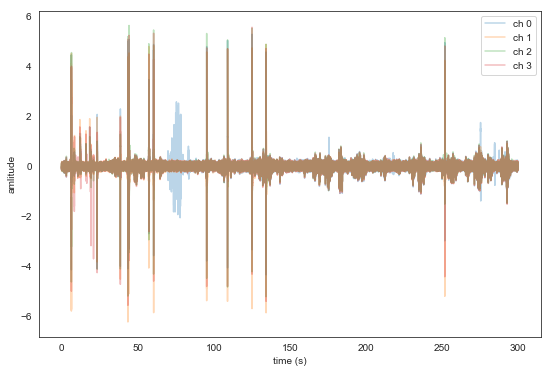

In [8]:
start_time = 0
stop_time = 300

mask = (start_time < times) & (times < stop_time) # seconds
plt.figure()
for ch in range(4):
    plt.plot(times[mask], np.array(anas)[mask, ch], alpha=.3, label='ch {}'.format(ch))
plt.ylabel('amlitude')
plt.xlabel('time (s)')
plt.legend()

In [10]:
def mask_coi(power, freqs, coi):
    periods = 1 / freqs
    for i in range(power.shape[1]):
        mask = periods > coi[i]
        power[mask, i] = np.nan

Text(0.5, 0, 'time (s)')

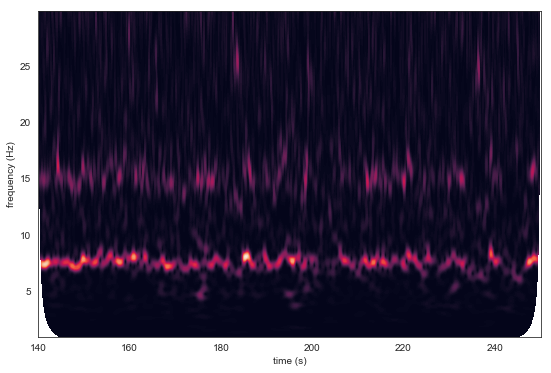

In [11]:
start_time = 140
stop_time = 250

mask = (start_time < times) & (times < stop_time) # seconds

mother = pycwt.Morlet(20) # Morlet size
freqs = np.arange(1, 30, .1) # Frequency range

wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data[mask], sampling_period, freqs=freqs, wavelet=mother)

power = (np.abs(wave)) ** 2
power /= scales[:, None] #rectify the power spectrum according to suggestions proposed by Liu et al. (2007)

mask_coi(power, freqs, coi)

plt.figure()
plt.contourf(times[mask], freqs, power, levels=100)
    
plt.ylabel('frequency (Hz)')
plt.xlabel('time (s)')

(0, 100)

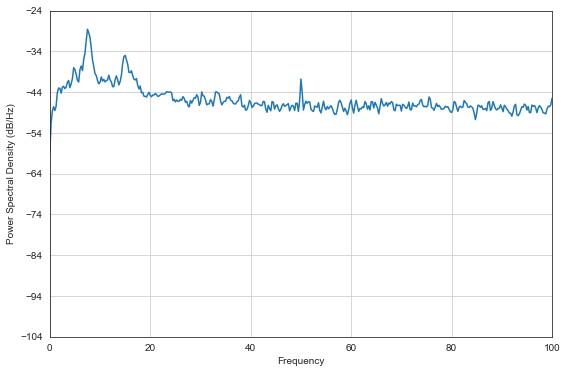

In [13]:
start_time = 140
stop_time = 250

mask = (start_time < times) & (times < stop_time) # seconds

plt.figure()
plt.psd(data[mask], Fs=sampling_rate, NFFT=4000)
plt.xlim(0,100)

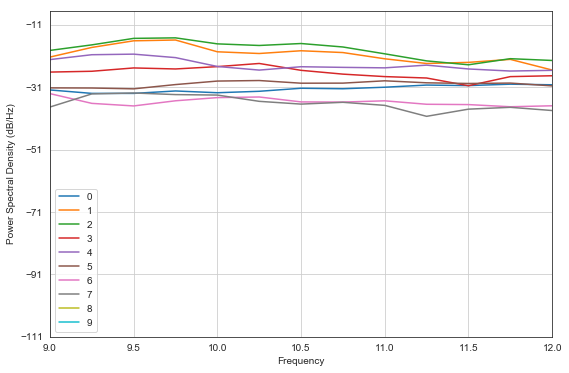

In [20]:
plt.figure()
res = []
for a in range(10):
    start_time = 0 + a * 100
    stop_time = 100 + a * 100

    mask = (start_time < times) & (times < stop_time) # seconds

    res.append(plt.psd(data[mask], Fs=sampling_rate, NFFT=4000, label=str(a)))
    plt.xlim(9,12)
plt.legend()